In [ ]:
#Comentário pós aula






#

# Aula 3 - Árvore de Decisão

Nesta aula, vamos explorar os tipos de modelos baseados na estrutura de uma **árvore de decisão**, enfocando, neste momento, problemas de classificação.

____

## Estrutura de uma árvore de decisão:

<img src="https://i1.wp.com/www.vooo.pro/insights/wp-content/uploads/2016/12/RDS-Vooo_insights-Tutorial_arvore_de_decisao_02.jpg?resize=640%2C371&ssl=1" width=600>

**Alguns exemplos:**

<img src="https://web.tecnico.ulisboa.pt/ana.freitas/bioinformatics.ath.cx/bioinformatics.ath.cx/uploads/RTEmagicC_arv_dec4_01.gif.gif" width=500>


<img src="https://didatica.tech/wp-content/uploads/2020/07/image-3.png" width=500>

Agora, conheceremos árvores como **estimadores**, de modo que á arvore **irá determinar sua estrutura com base nos dados de treino**!

Isto é, a árvore irá determinar **quais são as melhores quebras** a serem feitas em cada nó.

Entenderemos mais à frente como a "qualidade" de uma quebra é quantificada.

Antes, vamos construir um modelo de árvore na prática!

___

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') #ignorar os avisos de depreciação

Para o exemplo de árvore de descisão iremos utilizar um [dataset de risco de crédito](https://www.kaggle.com/uciml/german-credit). 

O objetivo é determinar a quais clientes será concedido crédito, com base em diversas features, descritas abaixo:

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [2]:
df = pd.read_csv('datasets/german_credit_data.csv', index_col=0) #coluna 0 será o index

In [3]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [5]:
df_model = df.select_dtypes(include=np.number) #cria o df_model (que terá apenas dados numéricos)

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Age            1000 non-null   int64
 1   Job            1000 non-null   int64
 2   Credit amount  1000 non-null   int64
 3   Duration       1000 non-null   int64
dtypes: int64(4)
memory usage: 39.1 KB


In [7]:
df_model

,Age,Job,Credit amount,Duration
0,67,2,1169,6
1,22,2,5951,48
2,49,1,2096,12
3,45,2,7882,42
4,53,2,4870,24
...,...,...,...,...
995,31,1,1736,12
996,40,3,3857,30
997,38,2,804,12
998,23,2,1845,45


In [8]:
df_model = pd.concat([df_model, df["Risk"]], axis=1) #função concat() junta as colunas dos parênteses
#axis=0 deixa o df mais longo (inclui dados em baixo dos atuais)
#axis=1 inclui a coluna "Risk" do lado (direito) do modelo atual

In [9]:
df_model

,Age,Job,Credit amount,Duration,Risk
0,67,2,1169,6,good
1,22,2,5951,48,bad
2,49,1,2096,12,good
3,45,2,7882,42,good
4,53,2,4870,24,bad
...,...,...,...,...,...
995,31,1,1736,12,good
996,40,3,3857,30,good
997,38,2,804,12,good
998,23,2,1845,45,bad


Há um desbalanço considerável no target, mas, por enquanto, não vamos nos preocupar em endereçar isso na partida. Vamos apenas garantir que a proporção é mantida após o train-test split, quando formos fazê-lo


In [10]:
df_model['Risk'].value_counts(normalize=True)

good    0.7
bad     0.3
Name: Risk, dtype: float64

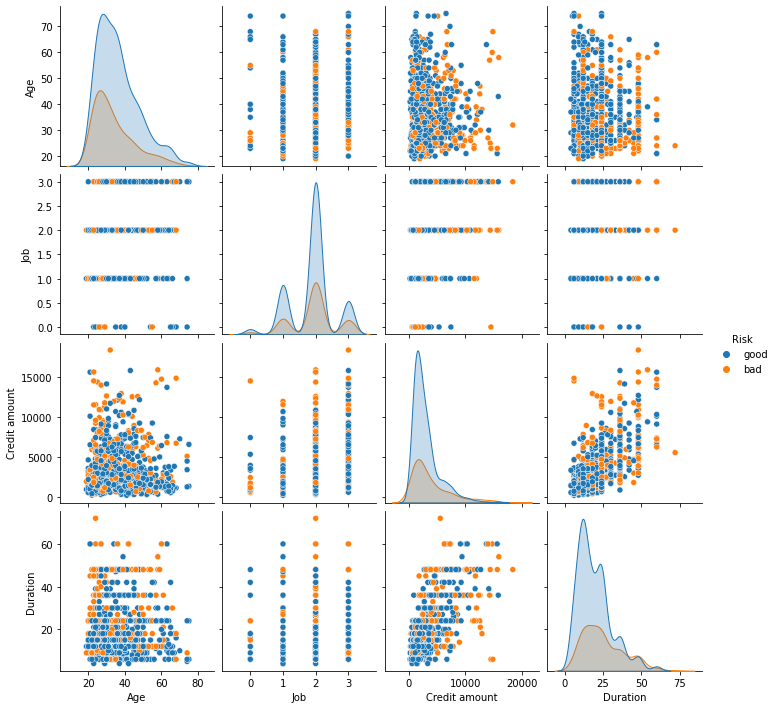

In [11]:
sns.pairplot(data=df_model, hue="Risk") #cria um tabuleiro com todas as colunas numéricas
#hue='Risk' - colore os pontos de acordo com a coluna Risk
#Na diagonal - histograma de como os dados daquela variável estão distribuídas

Temos duas colunas com dados missing. É importante que estes missing sejam tratados adequadamente: ou que estas linhas sejam **deletadas**, ou que os **dados nulos sejam preenchidos**. 

Na primeira versão de nosso modelo, vamos desconsiderar todas as linhas com missing (e, além disso, vamos utilizar apenas as features numéricas).

Vamos construir um classificador de árvore de decisão, cuja classe é a [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [12]:
X = df_model.drop(columns='Risk') #Features: X será todos os dados menos o Risk
y = df_model['Risk'] #Target: y será o Risk

In [13]:
from sklearn.model_selection import train_test_split #dividir treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#test_size = 20% dos dados será de teste e 80% de treino
#random_state = seed de randomização
#stratify=y mantém a proporção de 70% bom e 30% ruim do target Risk

In [14]:
y_train.value_counts(normalize=True)

good    0.7
bad     0.3
Name: Risk, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

good    0.7
bad     0.3
Name: Risk, dtype: float64

In [16]:
df_model.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


Vamos, agora, modelar o problema com uma árvore de decisão!

In [23]:
from sklearn.tree import DecisionTreeClassifier #importar a árvore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
#Matriz de Confusão é uma tabela que mostra o desempenho do algoritmo comparando o que ele previu com o que realmente aconteceu.
#ConfusionMatrixDisplay - transforma em um mapa de calor visual
#classification_report - gera um relatório com métricas detalhadas


Métricas de avaliação de treino:
[[240   0]
 [  0 560]]


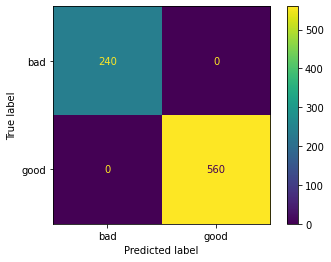

              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       240
        good       1.00      1.00      1.00       560

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Métricas de avaliação de teste:
[[ 23  37]
 [ 38 102]]


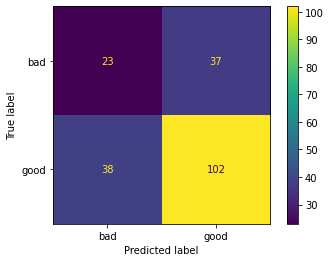

              precision    recall  f1-score   support

         bad       0.38      0.38      0.38        60
        good       0.73      0.73      0.73       140

    accuracy                           0.62       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.63      0.62      0.63       200



In [24]:
# ============================================

dt = DecisionTreeClassifier().fit(X_train, y_train) # treinando o modelo
# O algoritmo cria os nós para separar o Good e Bad
    
# ============================================

print("\nMétricas de avaliação de treino:") #roda a avaliação do treino

y_pred_train = dt.predict(X_train) #y_pred_train vira a predição do X_train (o que o modelo acha que é y_train)

print(confusion_matrix(y_train, y_pred_train)) #compara a predição (y_pred_train) com a resposta real (y_train)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train) 
#O .from_predictions() recebe os valores reais (y_train) e as predições (y_pred_train), 
#calcula os acertos e erros e já desenha o gráfico com as cores e rótulos.

plt.show()

print(classification_report(y_train, y_pred_train)) #boletim detalhado do modelo

# ============================================

print("\nMétricas de avaliação de teste:") #apresenta a avaliação do teste

y_pred_test = dt.predict(X_test) #y_pred_test vira a predição do X_test

print(confusion_matrix(y_test, y_pred_test)) #compara o modelo com a realidade

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test) #calcula acertos e erros
plt.show()

print(classification_report(y_test, y_pred_test))

In [ ]:
"""
Precisão do bad = 38% - baixíssimo desempenho
- De cada 100 maus pagadores reais, o seu modelo só consegue detectar 38

Precisão do good = 73% - baixo, mas melhor

accuracy = 62% (pior que o chute viciado na classe majoritária (70% dos dados reais já são good)

Diagnóstico da IA:
Por que isso aconteceu? (Diagnóstico)
Overfitting: Como você usou uma DecisionTreeClassifier() sem parâmetros, ela provavelmente "decorou" 
os dados de treino e agora está perdida nos dados de teste.

Desbalanceamento: Você tem muito mais casos "Good" do que "Bad". O modelo tende a favorecer a classe que ele mais vê.

Complexidade: Árvores de decisão sozinhas costumam ser instáveis para esse tipo de problema tabular.

Como melhorar esses números?
Para tirar o modelo do "vermelho", você pode tentar:

Podar a Árvore: Use max_depth=5 ou min_samples_leaf=10 ao criar o modelo para evitar que ele decore o treino.

Ajustar o Peso das Classes: Use DecisionTreeClassifier(class_weight='balanced'). Isso força o modelo a 
dar mais importância para a classe "Bad".

Trocar o Algoritmo: Teste um RandomForestClassifier. Ele costuma subir esse F1-score significativamente 
por ser um conjunto de várias árvores trabalhando juntas.
"""

___
A performance próxima ao "100%" no conjunto de treino e a queda considerável em performance nos dados de teste sugere um cenário de **overfitting!**

Por que isso pode ter acontecido? Vamos discutir mais sobre isso adiante, mas o fato é que o método de árvore de decisão é notoriamente **propenso a overfitting**.

Para entender o porquê, vamos dar uma olhada na árvore treinada!

In [ ]:
#O Overfitting (ou "sobreajuste") acontece quando o seu modelo de Machine Learning 
#aprende os dados de treino tão bem que ele acaba decorando o "ruído" e os detalhes irrelevantes, 
#em vez de aprender o padrão geral.

__Visualizando a árvore de decisão__

É possível visualizar a árvore de decisão criada com o próprio sklearn!

Para isso, basta usar a função `plot_tree()` do sub-módulo tree, conforme abaixo!

Para mais detalhes sobre como plotar a árvore, [clique aqui](https://scikit-learn.org/stable/modules/tree.html#tree)

In [25]:
from sklearn.tree import plot_tree

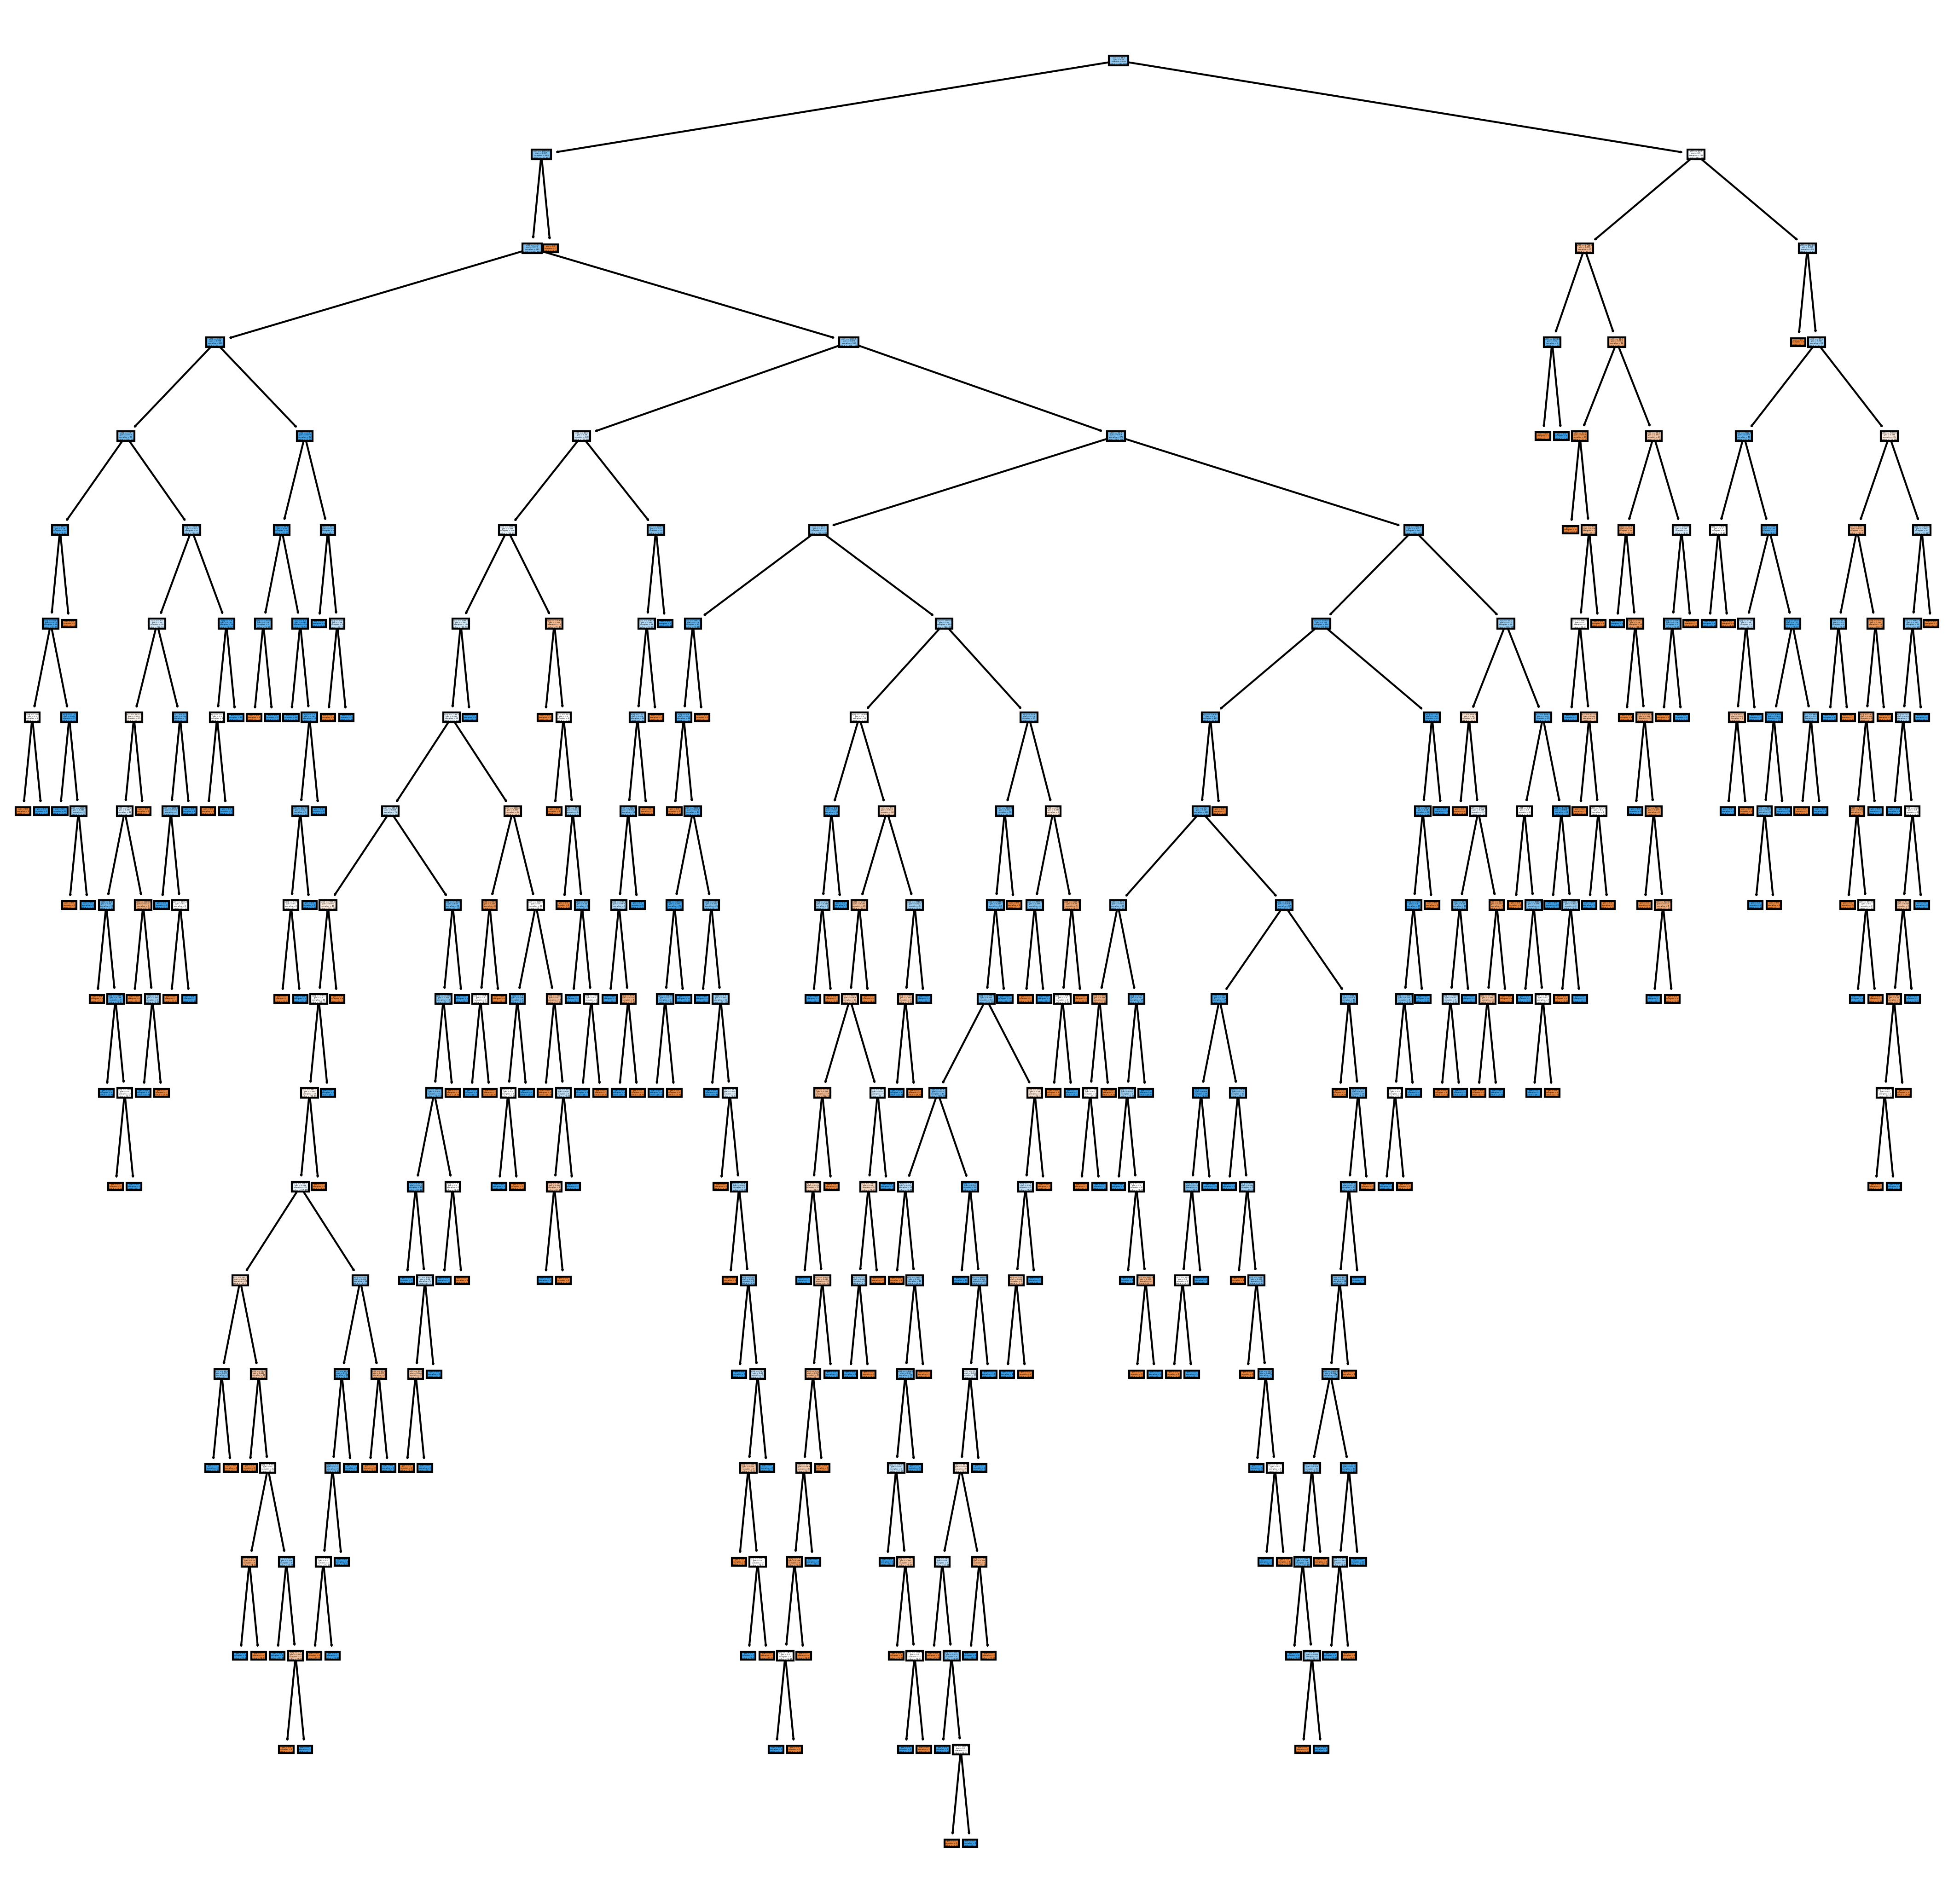

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 18), dpi=300)
#dpi = densidade de pixels (alta qualidade)
plot_tree(dt, filled=True); #filled=True adiciona cores nos nós

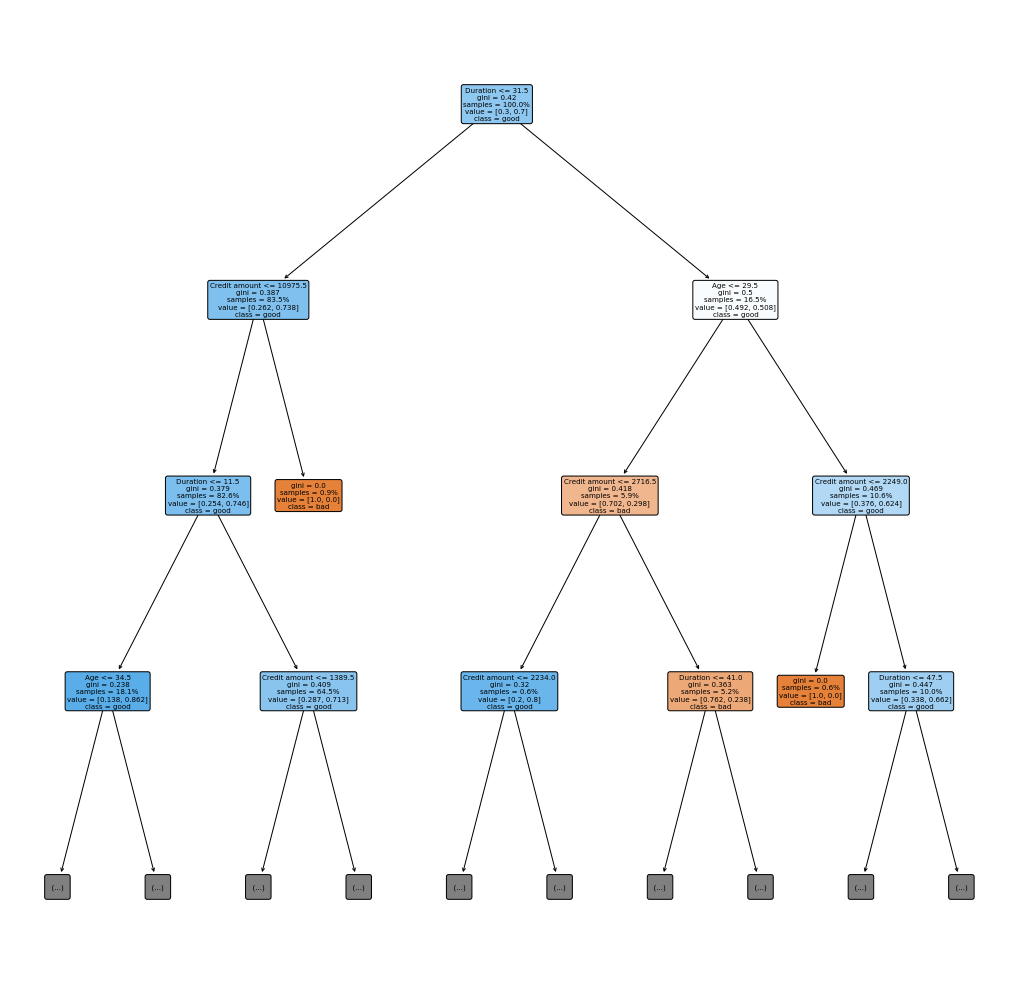

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))

plot_tree(dt, feature_names=X_train.columns.to_list(), max_depth=3, filled=True, class_names=['bad','good'], proportion=True, rounded=True) 
#, impurity=True
#max_depth=3 - limita o crescimento da árvore
#proportion=True - mostra percentual de amostras, não números absolutos

fig.savefig("arvore2.png")

Alguns métodos interessantes da árvore:

In [29]:
dt.get_depth() #qual é a profundidade da árvore

19

In [30]:
dt.get_n_leaves() #quantidade de folhas

234

Temos uma árvore **muito profunda**, o que implica em um **modelo muito complexo**.

De fato, se imaginarmos a hipótese como uma função definida por partes, quanto mais quebras, mais partes, o que torna a hipótese mais complexa, e, portanto, mais propensa a overfitting!

Uma visualização do que acontece com o espaço de features:

<img src=https://paulvanderlaken.files.wordpress.com/2020/03/readme-titanic_plot-11.png width=500>

Antes de avançarmos na direção de melhoria deste cenário, vamos parar e entender um pouco mais a fundo como que o estimador de árvore de decisão funciona!

_______

Agora que vimos na prática o modelo de árvore de decisão, vamos entender como **a árvore é construída com base nos dados de treino**!

__Exemplo__

Digamos que uma amostra de 30 alunos tem duas variáveis: Sexo (menino ou menina), Turma (IX ou X). 

Digamos também que 15 destes 30 jogam tênis no recreio. 

A árvore de decisão segregará os alunos com base nos valores das variáveis e **identificará a variável que cria os melhores conjuntos homogêneos de alunos** quanto ao target: quem joga tênis, e quem não joga.

Toda árvore começa pelo nó raiz, então, uma pergunta natural é: **qual feature utilizamos para fazer a quebra do nó raiz: sexo ou turma?**

Há duas quebras possíveis:

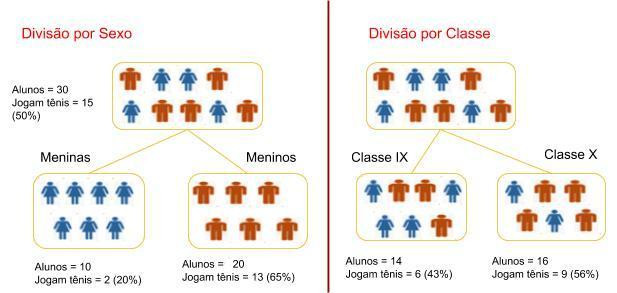

Vemos que, **dependendo da feature que utilizamos pra fazer a quebra**, conseguimos **graus de separações diferentes dos dados com relação ao target**:


<table>
<thead>
  <tr>
    <th colspan="4"><center>Sexo</center></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td colspan="2"><center>Meninas</center></td>
    <td colspan="2"><center>Meninos</center></td>
  </tr>
  <tr>
    <td><center>jogam tênis</center></td>
    <td><center>NÃO jogam tênis</center></td>
    <td><center>jogam tênis</center></td>
    <td><center>NÃO jogam tênis</center></td>
  </tr>
  <tr>
    <td><center>2</center></td>
    <td><center>8</center></td>
    <td><center>13</center></td>
    <td><center>7</center></td>
  </tr>
  <tr>
    <td colspan="2"><center>10</center></td>
    <td colspan="2"><center>20</center></td>
  </tr>
</tbody>
</table>


<table>
<thead>
  <tr>
    <th colspan="4"><center>turma</center></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td colspan="2"><center>IX</center></td>
    <td colspan="2"><center>X</center></td>
  </tr>
  <tr>
    <td><center>jogam tênis</center></td>
    <td><center>NÃO jogam tênis</center></td>
    <td><center>jogam tênis</center></td>
    <td><center>NÃO jogam tênis</center></td>
  </tr>
  <tr>
    <td><center>6</center></td>
    <td><center>8</center></td>
    <td><center>9</center></td>
    <td><center>7</center></td>
  </tr>
  <tr>
    <td colspan="2"><center>14</center></td>
    <td colspan="2"><center>16</center></td>
  </tr>
</tbody>
</table>

Como decidir qual das quebrar acima **separou melhor os dados com relação ao target?**

Matematicamente, o modelo pode usar dois critérios diferentes para decidir como fazer as quebras na árvore: o **critério de Gini** ou o **critério da entropia**.

Ambos os critérios utilizam medidas estatísticas que devem ser maximizadas, ou minimizadas, a depender do caso, para otimizar a quebra em cada nó da árvore! Desta forma, escapamos da arbitrariedade na definição dos limiares dos nós.